In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [86]:
data = pd.read_csv("CarPrice_Assignment.csv")

print("--- Data Head ---")
print(data.head())

print("\n--- Data Info ---")
data.info()

--- Data Head ---
   car_ID  symboling                   CarName fueltype aspiration doornumber  \
0       1          3        alfa-romero giulia      gas        std        two   
1       2          3       alfa-romero stelvio      gas        std        two   
2       3          1  alfa-romero Quadrifoglio      gas        std        two   
3       4          2               audi 100 ls      gas        std       four   
4       5          2                audi 100ls      gas        std       four   

       carbody drivewheel enginelocation  wheelbase  ...  enginesize  \
0  convertible        rwd          front       88.6  ...         130   
1  convertible        rwd          front       88.6  ...         130   
2    hatchback        rwd          front       94.5  ...         152   
3        sedan        fwd          front       99.8  ...         109   
4        sedan        4wd          front       99.4  ...         136   

   fuelsystem  boreratio  stroke compressionratio horsepower  

In [87]:
data_processed = data.copy()

In [88]:
door_map = {'two': 2, 'four': 4}
cylinder_map = {
    'two': 2, 'three': 3, 'four': 4, 'five': 5,
    'six': 6, 'eight': 8, 'twelve': 12
}

data_processed['doornumber'] = data_processed['doornumber'].map(door_map)
data_processed['cylindernumber'] = data_processed['cylindernumber'].map(cylinder_map)

print("--- Data after mapping 'two' -> 2 ---")
print(data_processed[['doornumber', 'cylindernumber']].head())

--- Data after mapping 'two' -> 2 ---
   doornumber  cylindernumber
0           2               4
1           2               4
2           2               6
3           4               4
4           4               5


In [89]:
print(data.isnull().sum())

car_ID              0
symboling           0
CarName             0
fueltype            0
aspiration          0
doornumber          0
carbody             0
drivewheel          0
enginelocation      0
wheelbase           0
carlength           0
carwidth            0
carheight           0
curbweight          0
enginetype          0
cylindernumber      0
enginesize          0
fuelsystem          0
boreratio           0
stroke              0
compressionratio    0
horsepower          0
peakrpm             0
citympg             0
highwaympg          0
price               0
dtype: int64


In [90]:
numeric_features = [
    'symboling', 'wheelbase', 'carlength', 'carwidth', 'carheight', 
    'curbweight', 'enginesize', 'boreratio', 'stroke', 
    'compressionratio', 'horsepower', 'peakrpm', 'citympg', 'highwaympg',
    'doornumber', 'cylindernumber' 
]

categorical_features = [
    'fueltype', 'aspiration', 'carbody', 'drivewheel', 
    'enginelocation', 'enginetype', 'fuelsystem'
]

dummies = pd.get_dummies(data_processed[categorical_features], drop_first=True, dtype=float)

final_data = pd.concat([
    data_processed[numeric_features], 
    dummies, 
    data_processed['price']
], axis=1)


print(f"--- Final Processed Data (all numbers) ---")
print(f"Original data had {data.shape[1]} columns.")
print(f"New data has {final_data.shape[1]} columns after encoding.")
print(final_data.head())

--- Final Processed Data (all numbers) ---
Original data had 26 columns.
New data has 39 columns after encoding.
   symboling  wheelbase  carlength  carwidth  carheight  curbweight  \
0          3       88.6      168.8      64.1       48.8        2548   
1          3       88.6      168.8      64.1       48.8        2548   
2          1       94.5      171.2      65.5       52.4        2823   
3          2       99.8      176.6      66.2       54.3        2337   
4          2       99.4      176.6      66.4       54.3        2824   

   enginesize  boreratio  stroke  compressionratio  ...  enginetype_ohcv  \
0         130       3.47    2.68               9.0  ...              0.0   
1         130       3.47    2.68               9.0  ...              0.0   
2         152       2.68    3.47               9.0  ...              1.0   
3         109       3.19    3.40              10.0  ...              0.0   
4         136       3.19    3.40               8.0  ...              0.0   

   

In [91]:
# X is all columns EXCEPT 'price'
X = final_data.drop('price', axis=1).values

# y the 'price' column
y = final_data['price'].values

print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

Shape of X: (205, 38)
Shape of y: (205,)


In [92]:
def train_test_split(X, y, test_size=0.2, random_seed=42):
    np.random.seed(random_seed)
    indices = np.random.permutation(len(X))
    test_set_size = int(len(X) * test_size)
    test_indices = indices[:test_set_size]
    train_indices = indices[test_set_size:]
    X_train, X_test = X[train_indices], X[test_indices]
    y_train, y_test = y[train_indices], y[test_indices]
    return X_train, X_test, y_train, y_test

def standardize(X_train, X_test):
    mean = np.mean(X_train, axis=0)
    std = np.std(X_train, axis=0)
    std[std == 0] = 1  
    X_train_scaled = (X_train - mean) / std
    X_test_scaled = (X_test - mean) / std
    return X_train_scaled, X_test_scaled

def add_intercept_term(X):
    intercept = np.ones((X.shape[0], 1))
    return np.concatenate((intercept, X), axis=1)

In [93]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_seed=42)

X_train_scaled, X_test_scaled = standardize(X_train, X_test)

X_train_final = add_intercept_term(X_train_scaled)
X_test_final = add_intercept_term(X_test_scaled)

print(f"Training data shape: {X_train_final.shape}")
print(f"Testing data shape: {X_test_final.shape}")

Training data shape: (164, 39)
Testing data shape: (41, 39)


In [94]:
learning_rate = 0.01
n_iterations = 1000

In [95]:
m_samples, n_features = X_train_final.shape 
weights = np.zeros(n_features)  # Start all weights at 0
cost_history = [] 

In [96]:
print("Starting model training...")

for i in range(n_iterations):
    y_pred = np.dot(X_train_final, weights)
    
    error = y_pred - y_train
    
    gradient = (1 / m_samples) * np.dot(X_train_final.T, error)
    
    weights = weights - learning_rate * gradient
    
    cost = np.mean(error**2) / 2
    cost_history.append(cost)
    
    if (i+1) % 100 == 0:
        print(f"Iteration {i+1}/{n_iterations}, Cost: {cost:.2f}")

print("Model training complete.")

Starting model training...
Iteration 100/1000, Cost: 15547344.15
Iteration 200/1000, Cost: 4581738.24
Iteration 300/1000, Cost: 2933220.01
Iteration 400/1000, Cost: 2599466.63
Iteration 500/1000, Cost: 2474729.96
Iteration 600/1000, Cost: 2395519.13
Iteration 700/1000, Cost: 2333233.78
Iteration 800/1000, Cost: 2280825.68
Iteration 900/1000, Cost: 2235587.21
Iteration 1000/1000, Cost: 2196046.27
Model training complete.


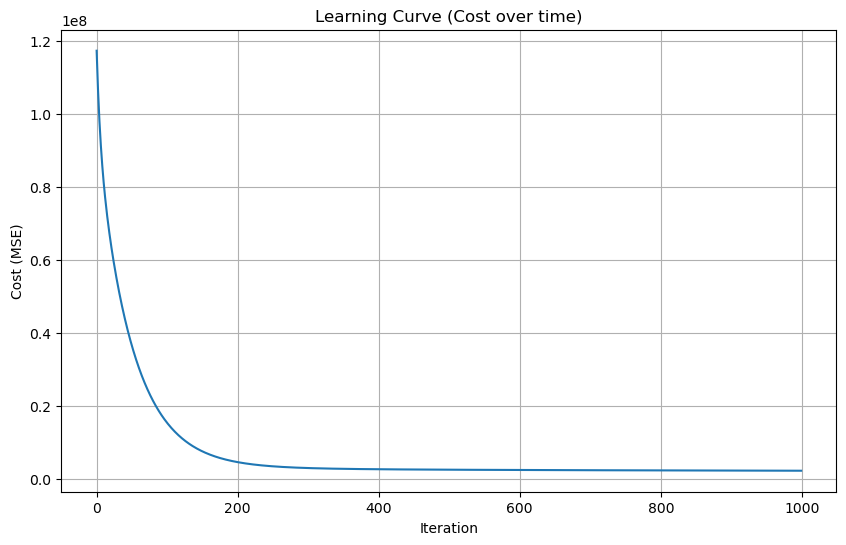

In [97]:
plt.figure(figsize=(10, 6))
plt.plot(range(n_iterations), cost_history)
plt.title("Learning Curve (Cost over time)")
plt.xlabel("Iteration")
plt.ylabel("Cost (MSE)")
plt.grid(True)
plt.show()

In [98]:
def mean_squared_error(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def r2_score(y_true, y_pred):
    ss_total = np.sum((y_true - np.mean(y_true)) ** 2)
    ss_residual = np.sum((y_true - y_pred) ** 2)
    return 1 - (ss_residual / ss_total)

In [99]:
y_pred_test = np.dot(X_test_final, weights)

mse = mean_squared_error(y_test, y_pred_test)
r2 = r2_score(y_test, y_pred_test)

print("\n--- Model Evaluation on Test Set ---")
print(f"Mean Squared Error (MSE): {mse:,.2f}") 
print(f"R-squared (R2 Score):     {r2:.4f}")


--- Model Evaluation on Test Set ---
Mean Squared Error (MSE): 14,693,641.17
R-squared (R2 Score):     0.8139


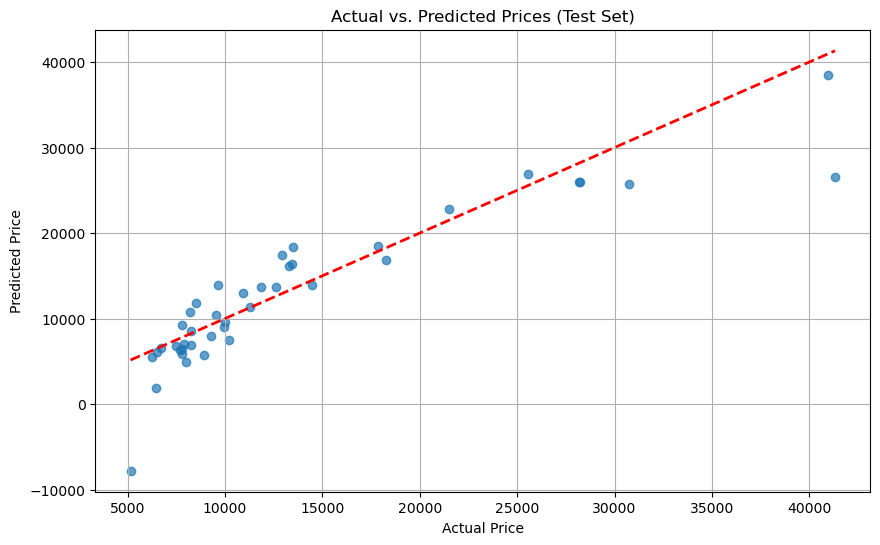

In [100]:
# Plot actual vs. predicted prices
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_test, alpha=0.7)
plt.title('Actual vs. Predicted Prices (Test Set)')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')


plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.grid(True)
plt.show()